In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import random

# Config

BATCH_SIZE = 32
IMG_SIZE = 300
EPOCHS_PHASE_A = 10
EPOCHS_PHASE_B = 10
LR_PHASE_A = 1e-3
LR_PHASE_B = 1e-5
DATA_ROOT = r"D:\dataset_split"
N_LAST_LAYERS = 200
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


# MixUp / CutMix utils

def mixup_data(x, y, alpha = 0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha = 1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size, _, H, W = x.size()
    index = torch.randperm(batch_size).to(x.device)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    w = int(W * np.sqrt(1 - lam))
    h = int(H * np.sqrt(1 - lam))
    x1 = np.clip(cx - w // 2, 0, W)
    x2 = np.clip(cx + w // 2, 0, W)
    y1 = np.clip(cy - h // 2, 0, H)
    y2 = np.clip(cy + h // 2, 0, H)
    x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]
    lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# CBAM implementation

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared_mlp = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias = False),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias = False)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.shared_mlp(self.avg_pool(x))
        max_out = self.shared_mlp(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding = padding, bias = False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = torch.mean(x, 1, keepdim = True)
        max_out, _ = torch.max(x, 1, keepdim = True)
        return self.sigmoid(self.conv(torch.cat([avg_out, max_out], 1)))

class CBAM(nn.Module):
    def __init__(self, channels, ratio = 16, kernel_size = 7):
        super().__init__()
        self.channel_att = ChannelAttention(channels, ratio)
        self.spatial_att = SpatialAttention(kernel_size)
    def forward(self, x):
        x = x * self.channel_att(x)
        x = x * self.spatial_att(x)
        return x


# Training function

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs, phase_name = "Phase", use_augmix = False):
    for epoch in range(epochs):
        model.train()
        running_loss, running_correct, total = 0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            # randomly choose MixUp or CutMix
            r = random.random()
            if use_augmix and r < 0.5:
                inputs, targets_a, targets_b, lam = mixup_data(imgs, labels)
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            elif use_augmix and r >= 0.5:
                inputs, targets_a, targets_b, lam = cutmix_data(imgs, labels)
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            if use_augmix:
                preds = outputs.argmax(1)
                running_correct += (lam * (preds == targets_a).float() + (1-lam)*(preds == targets_b).float()).sum().item()
            else:
                running_correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
        train_loss = running_loss / total
        train_acc = running_correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)
        val_loss /= val_total
        val_acc = val_correct / val_total
        print(f"{phase_name} Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
              f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    return model


if __name__ == "__main__":
    
    train_transform = transforms.Compose([
        transforms.RandAugment(num_ops = 3, magnitude = 9),
        transforms.RandomResizedCrop(IMG_SIZE, scale = (0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(f"{DATA_ROOT}/train", transform = train_transform)
    val_dataset = datasets.ImageFolder(f"{DATA_ROOT}/val", transform = val_transform)
    test_dataset = datasets.ImageFolder(f"{DATA_ROOT}/test", transform = val_transform)

    train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0, pin_memory = True)
    val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0, pin_memory = True)
    test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0, pin_memory = True)

    num_classes = len(train_dataset.classes)
    print("Classes:", train_dataset.classes)

    # Model: EfficientNet B3
    backbone = models.efficientnet_b3(weights = models.EfficientNet_B3_Weights.IMAGENET1K_V1)
    in_features = backbone.classifier[1].in_features

    class EfficientNet_CBAM(nn.Module):
        def __init__(self, backbone, cbam_channels, num_classes, in_features):
            super().__init__()
            self.backbone = backbone
            self.cbam = CBAM(cbam_channels)
            self.backbone.classifier = nn.Sequential(
                nn.Dropout(0.4),
                nn.Linear(in_features, num_classes)
            )
        def forward(self, x):
            x = self.backbone.features(x)
            x = self.cbam(x)
            x = self.backbone.avgpool(x)
            x = torch.flatten(x,1)
            x = self.backbone.classifier(x)
            return x

    model = EfficientNet_CBAM(backbone, cbam_channels = in_features, num_classes = num_classes, in_features = in_features).to(DEVICE)

    # Phase A: freeze backbone
    for name,param in model.named_parameters():
        param.requires_grad = False
    for name,param in model.named_parameters():
        if name.startswith("backbone.classifier") or name.startswith("cbam"):
            param.requires_grad = True
    optimizer = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr = LR_PHASE_A)
    criterion = nn.CrossEntropyLoss()
    model = train_model(model, criterion, optimizer, train_loader, val_loader, EPOCHS_PHASE_A, "Phase A", use_augmix = True)

    # Phase B: fine-tune last N layers
    for name,param in model.named_parameters():
        param.requires_grad = False
    all_params = list(model.named_parameters())
    if N_LAST_LAYERS > len(all_params):
        N_LAST_LAYERS = len(all_params)
    for name,param in all_params[-N_LAST_LAYERS:]:
        param.requires_grad = True
    for name,param in model.named_parameters():
        if name.startswith("backbone.classifier") or name.startswith("cbam"):
            param.requires_grad = True
    optimizer = optim.Adam(filter(lambda p:p.requires_grad, model.parameters()), lr = LR_PHASE_B)
    model = train_model(model, criterion, optimizer, train_loader, val_loader, EPOCHS_PHASE_B, "Phase B", use_augmix = True)

  
    # Save model

    torch.save(model.state_dict(), "D:/saved_models/efficientnet_b3_cbam_mixup_cutmix.pt")


Device: cuda
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Phase A Epoch [1/10] Train Loss: 1.8986 | Train Acc: 0.4434 | Val Loss: 0.9361 | Val Acc: 0.8076
Phase A Epoch [2/10] Train Loss: 1.5863 | Train Acc: 0.5334 | Val Loss: 0.8083 | Val Acc: 0.8382
Phase A Epoch [3/10] Train Loss: 1.5338 | Train Acc: 0.5478 | Val Loss: 0.6731 | Val Acc: 0.8683
Phase A Epoch [4/10] Train Loss: 1.5060 | Train Acc: 0.5566 | Val Loss: 0.6418 | Val Acc: 0.8698
Phase A Epoch [5/10] Train Loss: 1.5190 | Train Acc: 0.5482 | Val Loss: 0.6787 | Val Acc: 0.8601
Phase A Epoch [6/10] Train Loss: 1.4796 | Train Acc: 0.5648 | Val Loss: 0.5825 | Val 


Normal Test Accuracy: 0.9740

=== Normal Test Classification Report ===
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     0.9900    0.9802    0.9851       101
                     Pepper__bell___healthy     0.9933    0.9933    0.9933       149
                      Potato___Early_blight     0.9900    0.9900    0.9900       100
                       Potato___Late_blight     0.9900    0.9900    0.9900       100
                           Potato___healthy     0.9412    1.0000    0.9697        16
                      Tomato_Bacterial_spot     0.9548    0.9860    0.9701       214
                        Tomato_Early_blight     0.9444    0.8500    0.8947       100
                         Tomato_Late_blight     0.9735    0.9583    0.9659       192
                           Tomato_Leaf_Mold     0.9895    0.9792    0.9843        96
                  Tomato_Septoria_leaf_spot     0.9665    0.9719    0.9692  

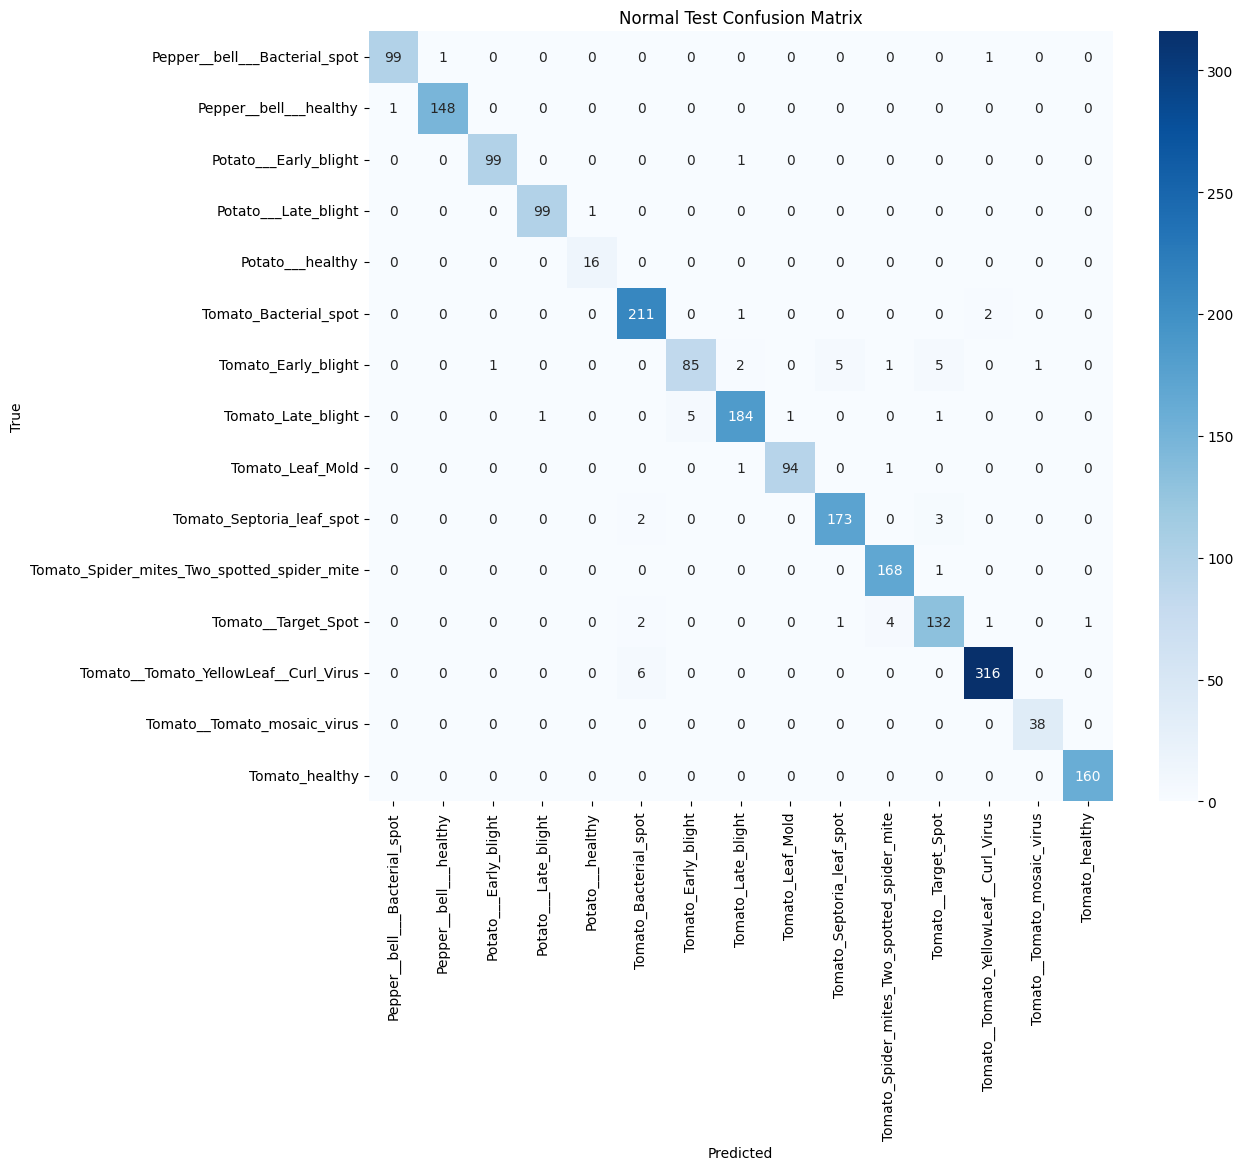

Hard Aug Test Accuracy: 0.9350

=== Hard Aug Test Classification Report ===
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     0.9691    0.9307    0.9495       101
                     Pepper__bell___healthy     0.9669    0.9799    0.9733       149
                      Potato___Early_blight     0.9238    0.9700    0.9463       100
                       Potato___Late_blight     0.9583    0.9200    0.9388       100
                           Potato___healthy     0.7273    1.0000    0.8421        16
                      Tomato_Bacterial_spot     0.9398    0.9486    0.9442       214
                        Tomato_Early_blight     0.9733    0.7300    0.8343       100
                         Tomato_Late_blight     0.9010    0.9479    0.9239       192
                           Tomato_Leaf_Mold     0.9216    0.9792    0.9495        96
                  Tomato_Septoria_leaf_spot     0.9682    0.8539    0.907

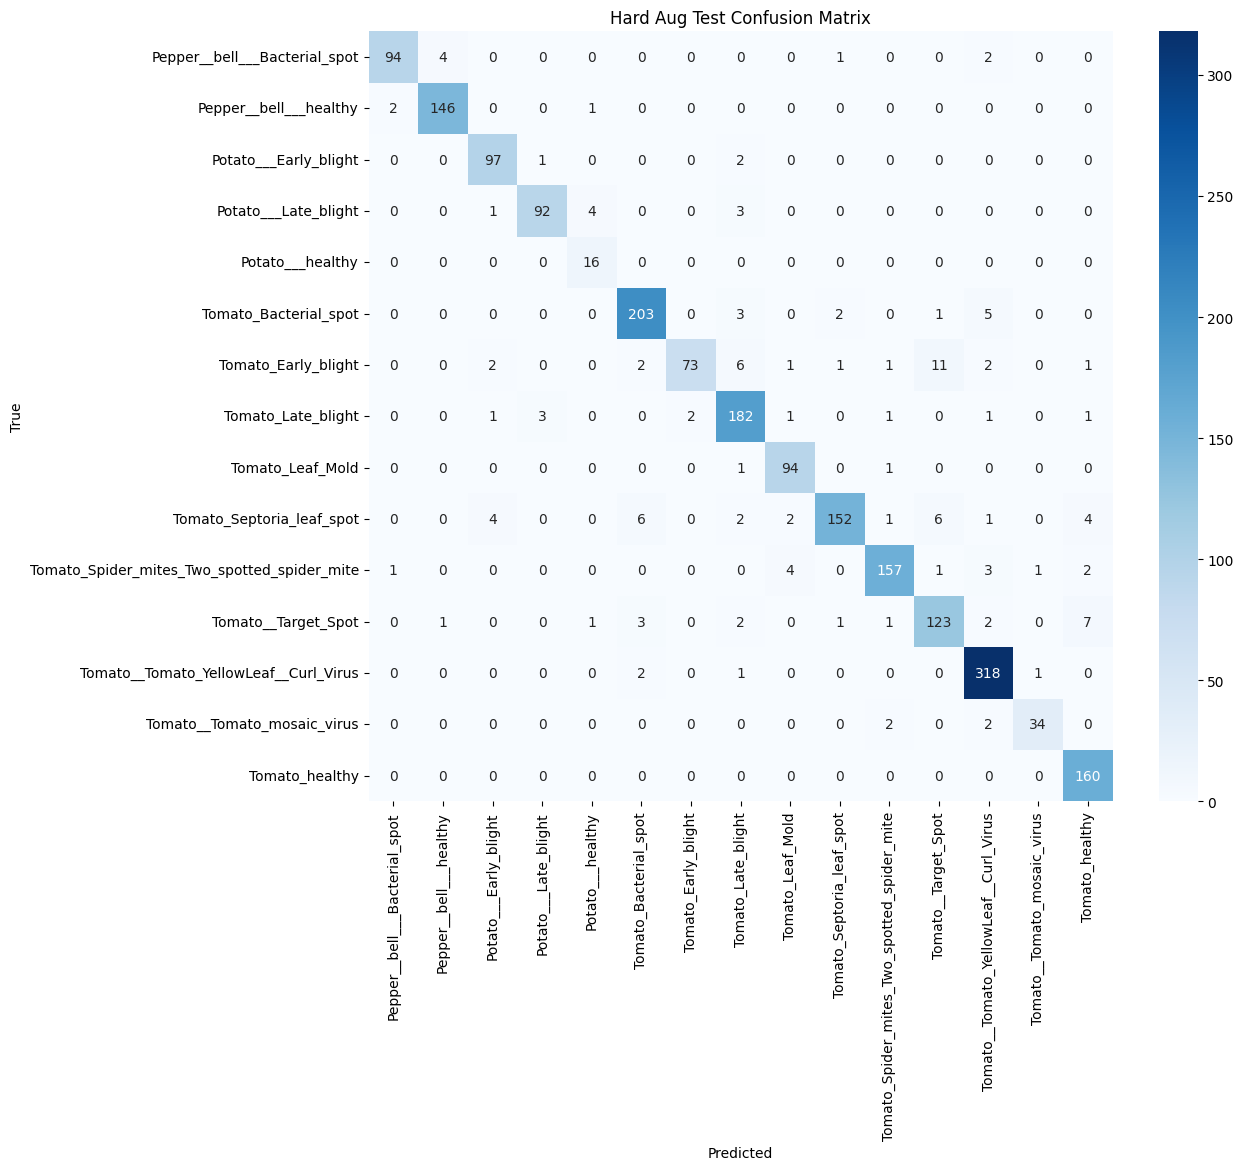

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_and_report(y_true, y_pred, class_names, desc = "Test"):
    print(f"\n=== {desc} Classification Report ===")
    print(classification_report(y_true, y_pred, target_names = class_names, digits = 4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (12, 10))
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues",
                xticklabels = class_names, yticklabels = class_names)
    plt.title(f"{desc} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Test normal

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
normal_acc = (all_preds == all_labels).sum() / len(all_labels)
print(f"\nNormal Test Accuracy: {normal_acc:.4f}")
evaluate_and_report(all_labels, all_preds, test_dataset.classes, desc = "Normal Test")


# Test hard aug

hard_test_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale = (0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(0.5, 0.5, 0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
hard_test_dataset = datasets.ImageFolder(f"{DATA_ROOT}/test", transform = hard_test_transform)
hard_test_loader = DataLoader(hard_test_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0)
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in hard_test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
hard_acc = (all_preds == all_labels).sum() / len(all_labels)
print(f"Hard Aug Test Accuracy: {hard_acc:.4f}")
evaluate_and_report(all_labels, all_preds, test_dataset.classes, desc = "Hard Aug Test")
